In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
from numpy.linalg import multi_dot
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from gtime.stat_tools.tools import mat_square
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  
%load_ext Cython


## TIme series

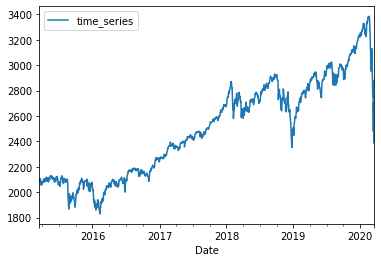

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

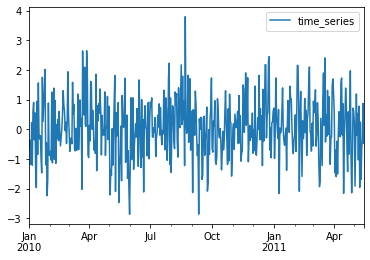

In [3]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

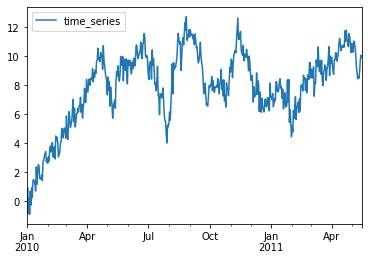

In [4]:
arm_np = np.zeros(501)
mean = 0.0
ar = -.4
ma = -.7
eps = np.random.standard_normal()
for i in range(1, 501):
    arm_np[i] = mean + ar * arm_np[i-1] + ma * eps
    eps = np.random.standard_normal()
arima_np = arm_np.cumsum()
df_arima = pd.DataFrame(arima_np)
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_arima = time_series_preparation.transform(df_arima)
df_arima.plot()

## Test functions

In [5]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [6]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=0.06, p=[0.03 0.03 0.04 0.02]
RMSE: 1.22



array([0.03, 0.03, 0.04, 0.02])

Giotto results mle:
Fitted parameters: mu=-0.00, p=[-0.81], q=[-0.2  -0.86  0.05  0.01]
AR roots abs:[1.23]
MA roots abs:[11.94  6.88  1.16  1.  ]
Train error mean: -0.48, std: 20.83
LL: 5155.19
RMSE: 48042.54



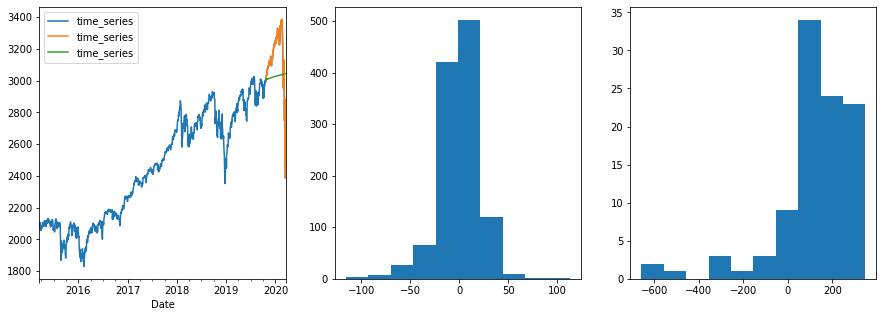

In [7]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    
#     model.model.model.phi = np.array([-0.94])
#     model.model.model.theta_ = np.array([-0.06, -1.,    0.03,  0.03])
#     model.model._set_params(model.model.model, df_train)
    
    pred_g = model.predict(df_test.iloc[[0]])
#     print(pred_g.values.flatten())
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.phi_
    theta = model.model.theta_
    mu = model.model.mu_
    train_errors = model.model.errors_
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
#     print(train_errors)
    print(f'LL: {model.model.model.ml:.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_real, 100, (1, 2, 4), 'mle')

Statsmodels results css:
Fitted parameters: mu=-0.00, p=[-0.94], q=[-0.06 -1.    0.03  0.03]
AR roots abs:[1.06]
MA roots abs:[1.   1.04 4.86 5.76]
Train error mean: -0.45, std: 20.82
LL: 5150.12
RMSE: 49918.90



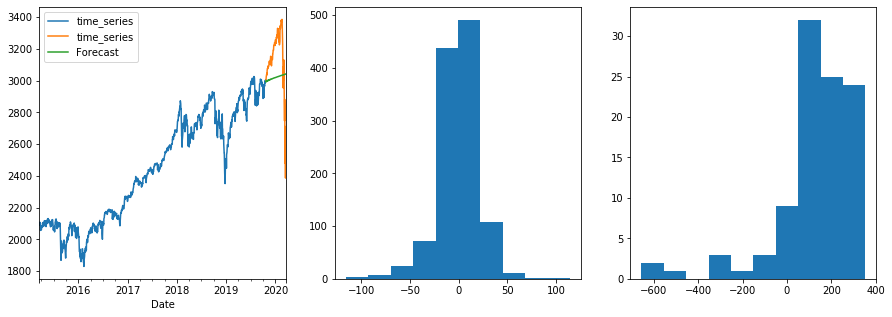

In [8]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'LL: {-f.llf:.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_real, 100, (1, 2, 4), 'css')

## Simple AR check

In [9]:
df = df_white
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=0.06, p=[0.03 0.04]
RMSE: 1.23

Statsmodels results css:
Fitted parameters: mu=0.05, p=[0.03 0.04], q=[]
AR roots abs:[4.64 5.38]
MA roots abs:[]
Train error mean: -0.00, std: 0.99
LL: 562.41
RMSE: 1.18

Statsmodels results mle:
Fitted parameters: mu=0.05, p=[0.03 0.04], q=[]
AR roots abs:[4.64 5.4 ]
MA roots abs:[]
Train error mean: 0.00, std: 0.99
LL: 564.57
RMSE: 1.18

Giotto results css:
Fitted parameters: mu=0.05, p=[0.03 0.04], q=[]
AR roots abs:[5.38 4.64]
MA roots abs:[]
Train error mean: -0.00, std: 0.99
LL: 562.41
RMSE: 1.17

Giotto results mle:
Fitted parameters: mu=0.05, p=[0.03 0.04], q=[]
AR roots abs:[5.39 4.64]
MA roots abs:[]
Train error mean: 0.00, std: 0.99
LL: 564.57
RMSE: 1.17



Basic AR results results:
Fitted parameters: mu=3.58, p=[0.98 0.02]
RMSE: 44772.60

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
LL: 5153.70
RMSE: 52639.91

Statsmodels results mle:
Fitted parameters: mu=2494.44, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   53.84]
MA roots abs:[]
Train error mean: 0.37, std: 23.82
LL: 5165.89
RMSE: 67607.63

Giotto results css:
Fitted parameters: mu=2442.09, p=[0.98 0.02], q=[]
AR roots abs:[54.01  1.  ]
MA roots abs:[]
Train error mean: 0.80, std: 20.81
LL: 5154.55
RMSE: 63804.23

Giotto results mle:
Fitted parameters: mu=2442.07, p=[0.98 0.02], q=[]
AR roots abs:[54.3  1. ]
MA roots abs:[]
Train error mean: 0.49, std: 23.11
LL: 5165.91
RMSE: 66018.77



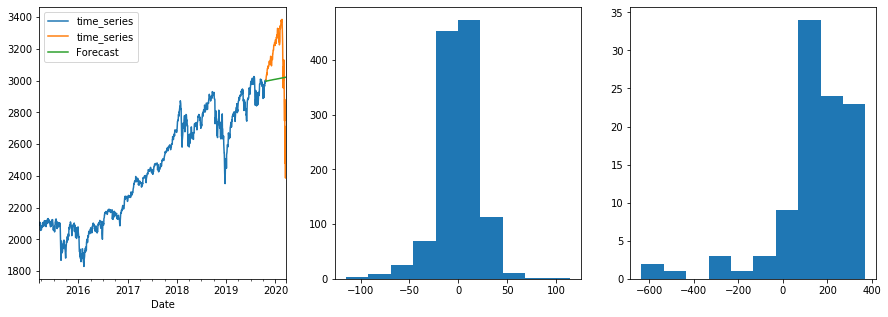

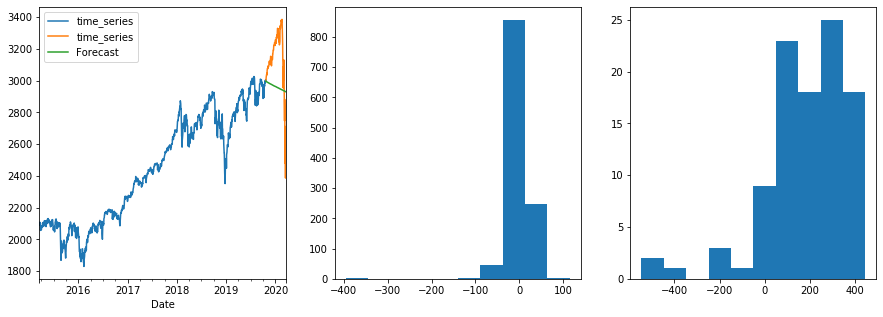

In [10]:
df = df_real
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=True);
run_sm(df, 100, (2, 0, 0), 'mle', plot=True);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

## Simple ARI check

In [11]:
df = df_white
order = (2, 1, 0)
run_sm(df, 100, order, 'css', plot=False);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=False);
run_giotto_arima(df, 100, order, 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.67 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.13
LL: 611.60
RMSE: 1.20

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.67 -0.33], q=[]
AR roots abs:[1.74 1.74]
MA roots abs:[]
Train error mean: 0.00, std: 1.13
LL: 613.96
RMSE: 1.20

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.67 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.13
LL: 611.60
RMSE: 2.23

Giotto results mle:
Fitted parameters: mu=0.00, p=[-0.67 -0.33], q=[]
AR roots abs:[1.73 1.73]
MA roots abs:[]
Train error mean: 0.00, std: 1.13
LL: 613.91
RMSE: 2.26



In [12]:
df = df_real
order = (2, 1, 0)
run_sm(df, 100, order, 'css', plot=False);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=False);
run_giotto_arima(df, 100, order, 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 46983.52

Statsmodels results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.77
LL: 5156.18
RMSE: 46931.59

Giotto results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
LL: 5147.77
RMSE: 45068.80

Giotto results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: -0.00, std: 20.77
LL: 5156.18
RMSE: 45021.36



In [13]:
df = df_arima
order = (2, 1, 0)
run_sm(df, 100, order, 'css', plot=False);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=False);
run_giotto_arima(df, 100, order, 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.02, p=[-0.43 -0.04], q=[]
AR roots abs:[3.71 6.08]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 430.44
RMSE: 5.70

Statsmodels results mle:
Fitted parameters: mu=0.02, p=[-0.44 -0.04], q=[]
AR roots abs:[3.57 6.26]
MA roots abs:[]
Train error mean: 0.00, std: 0.72
LL: 434.26
RMSE: 6.07

Giotto results css:
Fitted parameters: mu=0.02, p=[-0.43 -0.04], q=[]
AR roots abs:[6.08 3.71]
MA roots abs:[]
Train error mean: 0.00, std: 0.71
LL: 430.44
RMSE: 3.26

Giotto results mle:
Fitted parameters: mu=0.02, p=[-0.44 -0.04], q=[]
AR roots abs:[6.35 3.55]
MA roots abs:[]
Train error mean: 0.00, std: 0.72
LL: 434.26
RMSE: 3.53



## Full ARIMA check

In [14]:
df = df_white
order = (2, 1, 2)
run_sm(df, 100, order, 'css', plot=False);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=False);
run_giotto_arima(df, 100, order, 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.89  0.01], q=[-0.07 -0.85]
AR roots abs:[ 1.11 82.45]
MA roots abs:[1.05 1.13]
Train error mean: 0.01, std: 1.00
LL: 563.23
RMSE: 1.20

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.88  0.01], q=[-0.08 -0.84]
AR roots abs:[ 1.12 72.64]
MA roots abs:[1.05 1.14]
Train error mean: 0.01, std: 1.00
LL: 566.16
RMSE: 1.20

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.58  0.01], q=[-0.38 -0.55]
AR roots abs:[46.84  1.66]
MA roots abs:[1.73 1.05]
Train error mean: 0.01, std: 1.00
LL: 563.41
RMSE: 1.23

Giotto results mle:
Fitted parameters: mu=0.00, p=[-0.89  0.01], q=[-0.07 -0.84]
AR roots abs:[94.33  1.11]
MA roots abs:[1.13 1.05]
Train error mean: 0.01, std: 1.00
LL: 565.85
RMSE: 1.24



Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.26 -0.07], q=[-0.76 -0.24]
AR roots abs:[3.89 3.89]
MA roots abs:[1.   4.23]
Train error mean: -0.04, std: 20.78
LL: 5143.23
RMSE: 43110.28

Statsmodels results mle:
Fitted parameters: mu=0.00, p=[-0.88 -0.06], q=[-0.13 -0.87]
AR roots abs:[ 1.23 14.36]
MA roots abs:[1.   1.15]
Train error mean: 0.19, std: 20.80
LL: 5153.98
RMSE: 42925.20

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.26 -0.07], q=[-0.76 -0.24]
AR roots abs:[3.9 3.9]
MA roots abs:[4.23 1.  ]
Train error mean: -0.04, std: 20.78
LL: 5143.23
RMSE: 41590.48

Giotto results mle:
Fitted parameters: mu=-0.00, p=[-0.88 -0.05], q=[-0.13 -0.87]
AR roots abs:[15.51  1.23]
MA roots abs:[1.15 1.  ]
Train error mean: -0.45, std: 20.84
LL: 5155.29
RMSE: 47521.96



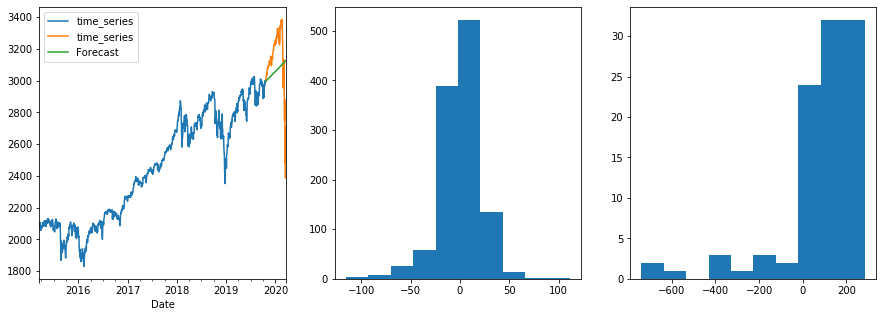

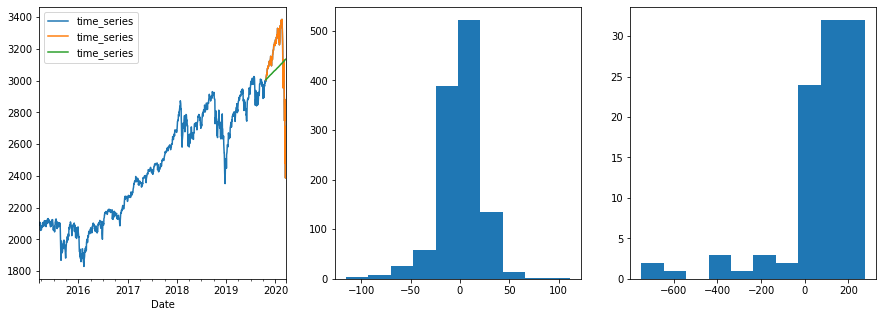

In [15]:
df = df_real
order = (2, 2, 2)
run_sm(df, 100, order, 'css', plot=True);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=True);
run_giotto_arima(df, 100, order, 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.01, p=[-1.59 -0.7 ], q=[ 1.17  0.13 -0.21]
AR roots abs:[1.19 1.19]
MA roots abs:[1.26 1.26 3.  ]
Train error mean: 0.00, std: 0.71
LL: 427.02
RMSE: 7.39

Statsmodels results mle:
Fitted parameters: mu=0.01, p=[-1.6  -0.79], q=[ 1.17  0.21 -0.28]
AR roots abs:[1.12 1.12]
MA roots abs:[1.14 1.14 2.74]
Train error mean: 0.00, std: 0.71
LL: 430.89
RMSE: 6.85

Giotto results css:
Fitted parameters: mu=0.01, p=[-1.59 -0.7 ], q=[ 1.17  0.13 -0.21]
AR roots abs:[1.19 1.19]
MA roots abs:[3.   1.26 1.26]
Train error mean: 0.00, std: 0.71
LL: 427.02
RMSE: 4.31

Giotto results mle:
Fitted parameters: mu=0.02, p=[0.16 0.59], q=[-0.61 -0.39  0.17]
AR roots abs:[1.44 1.17]
MA roots abs:[1.74 2.86 1.2 ]
Train error mean: 0.00, std: 0.71
LL: 432.81
RMSE: 3.49



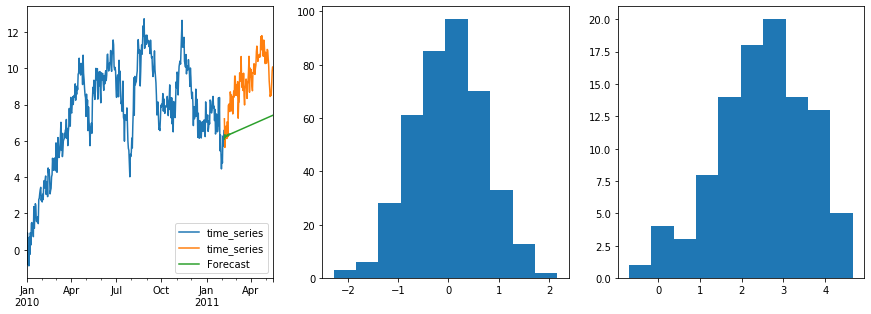

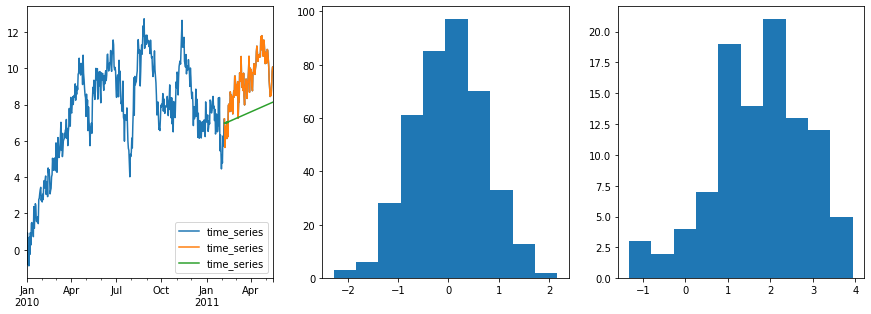

In [21]:
df = df_arima
order = (2, 1, 3)
run_sm(df, 100, order, 'css', plot=True);
run_sm(df, 100, order, 'mle', plot=False);
run_giotto_arima(df, 100, order, 'css', plot=True);
run_giotto_arima(df, 100, order, 'mle', plot=False);

## Performance tests

In [ ]:
%%cython -a
from scipy.linalg.cython_blas cimport dsymm, dgemm, dgemv, daxpy, dsyr, dcopy
from scipy.linalg.cython_lapack cimport dpotrf
from numpy cimport NPY_DOUBLE, npy_intp, PyArray_ZEROS, import_array, float64_t, ndarray
from numpy import zeros_like
from libc.math cimport log, M_PI

import_array()


def llf_c(double nu, double F):
    return llf_cp(nu, F)

cdef double llf_cp(double nu, double F):
    return -0.5 * (log(2 * M_PI * abs(F)) + nu * nu / F)


cdef void add_mat(double[::1, :] a, double[::1, :] b, int r, int c):
    
    cdef int i = 0
    cdef int j = 0
    
    for i in range(r):
        for j in range(c):
            a[i, j] = a[i, j] + b[i, j]
    

cdef void mat_square_c(double[::1, :] x, double[::1, :] q, int n):
    cdef int ldt = x.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef npy_intp r2shape[2] 
    r2shape[0] = <npy_intp> n
    r2shape[1] = <npy_intp> n
    cdef double[::1, :] res = PyArray_ZEROS(2, r2shape, NPY_DOUBLE, 1)
    dsymm('R', 'U', &n, &n, &one, &q[0, 0], &ldt, &x[0, 0], &ldt, &zero, &res[0, 0], &ldt)
    dgemm("N", "T", &n, &n, &n, &one, &res[0, 0], &ldt, &x[0, 0], &ldt, &zero, &x[0, 0], &ldt)


def roll(double[::1] x, double[::1] a, double[::1, :] p, double[::1] eps,
            double mu, double F, double nu,
            double[::1, :] rqr, double[::1, :] K,
           int r, int n):
    
    cdef int lda = a.strides[0] // sizeof(float64_t)
    cdef int ldk = K.strides[1] // sizeof(float64_t)
    cdef int ldp = p.strides[1] // sizeof(float64_t)
    cdef double one = 1.0
    cdef double zero = 0.0
    cdef double F_c = F
    cdef float64_t F_inv
    cdef float64_t nf
    cdef float64_t loglikelihood = 0.0
    cdef bint converged = False
    cdef int i = 0
    cdef double[::1] a_t = zeros_like(a, order='F')
    
    for i in range(n-1):
         
        if F_c == rqr[0, 0]:
            converged = True
        
        F_inv = -1.0 / F_c
        nf = -nu * F_inv

        if converged:
            # a = a + p[:, 0] * nu / F
            # a = np.matmul(K, a)
            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            
        else:
            # a = a + p[:, 0] * nu / F
            # p = p - np.dot(gain, pz.T)

            daxpy(&r, &nf, &p[0, 0], &ldp, &a[0], &lda)
            dsyr('L', &r, &F_inv, &p[0, 0], &ldp, &p[0, 0], &r)

            # a = np.matmul(K, a)
            # p = mat_square(p, K) + rqr
            # F = p[0, 0]

            dgemv('N', &r, &r, &one, &K[0, 0], &ldk, &a[0], &lda, &zero, &a_t[0], &lda)
            dcopy(&r, &a_t[0], &lda, &a[0], &lda)
            mat_square_c(p, K, r)
            add_mat(p, rqr, r, r)
            F_c = p[0, 0]

        nu = x[i+1] - a[0] - mu
        eps[i+1] = nu
        ll_last = llf_cp(nu, F_c)
        loglikelihood = loglikelihood + ll_last
    
    return loglikelihood, eps
    

In [ ]:
# previous "fast" version
def alt_likelihood_old(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros((m, 1))
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p_hat = p
    a_hat = a
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
#     print(K)
    for i, x in enumerate(X[1:]):
        
#         print('A0', '\t'.join(map(str, a_hat.flatten())))
        pz = p_hat[:, [0]]
        gain = pz / F
#         print('\t'.join(map(str, (gain * nu).flatten())))
        a = a_hat + gain * nu
        p = p_hat - np.dot(gain, pz.T)
#         print('A1', '\t'.join(map(str, a.flatten())))
        
        a_hat = np.matmul(K, a)
        p_hat = mat_square(p, K) + rqr
        x_hat = a_hat[0] + mu
        F = p_hat[0, 0]
#         print('A2', '\t'.join(map(str, a_hat.flatten())))
#         print('\t'.join(map(str, a.flatten())))

        nu = float(x - x_hat)
        eps[i] = nu
        LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
        loglikelihood += LL_last
    return loglikelihood, eps

In [ ]:
# Statsmodels wrapper
from statsmodels.tsa.kalmanf import kalman_loglike
def alt_likelihood_sm(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    eps, fs, ll = kalman_loglike.kalman_filter_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    llh, s = kalman_loglike.kalman_loglike_double(X, 1, len(phi), len(theta), r, n, Z, R, K)
    loglikelihood += ll
    return ll, eps, fs, llh, s

In [ ]:
# Cython engine wrapper
def alt_likelihood(X, mu, sigma, phi, theta, errors=False):

    m = len(phi)
    R = np.array([np.r_[1.0, theta[:-1]]]).T
    K = np.concatenate((phi[:-1].reshape((-1, 1)), np.identity(m - 1)), axis=1)
    K = np.concatenate((K, np.concatenate((phi[-1:], np.zeros(m - 1))).reshape(1, -1)))
    Q = np.array([[sigma ** 2]])
    Z = np.zeros((1, m))
    Z[0, 0] = 1.0
    eps = np.zeros(len(X))
    vec_RR = np.matmul(R, R.T).ravel()
    vec_K = np.linalg.inv(np.identity(m ** 2) - np.kron(K, K))
    p = sigma ** 2 * np.matmul(vec_K, vec_RR).reshape((m, m))
    a = np.zeros(m)
    x_hat = a[0] + mu
    nu = float(X[0] - x_hat)
    F = p[0, 0]

    p = np.array(p, order='F')
    K = np.array(K, order='F')
    
    LL_last = -0.5 * (np.log(2 * np.pi * np.abs(F)) + nu * nu / F)
    loglikelihood = LL_last
    eps[0] = nu
    rqr = mat_square(Q, R)
    rqr = np.array(rqr, order='F')
    r = p.shape[0]
    n = len(X)
    ll, eps = roll(X, a, p, eps, mu, F, nu, rqr, K, r, n)
    return loglikelihood + ll, eps

In [ ]:
# input data
x = df_arima.values.flatten()
# x -= x.mean()
phi = np.array([0.3, 0.2])
theta = np.array([0.1, 0.0])

In [ ]:
ll , eps_sm, f, ll_sm, s = alt_likelihood_sm(x, 0.0, 20.0, phi, theta)

In [ ]:
ll_g, eps_g = alt_likelihood(x, 0.0, 1.0, phi, theta)

In [ ]:
ll_g

In [ ]:
eps_sm.flatten() - np.array(eps_g)

In [ ]:
%timeit alt_likelihood_sm(x, 0.0, np.sqrt(s), phi, theta)

In [ ]:
%timeit alt_likelihood_old(x, 0.0, np.sqrt(s), phi, theta)

In [ ]:
%timeit alt_likelihood(x, 0.0, np.sqrt(s), phi, theta)

## Compiling

In [ ]:
from loglike import llf_c as llf_so

In [ ]:
! python3 setup.py build_ext --inplace

## Optimization